# Linear Regression with a Real Dataset

https://colab.research.google.com/github/google/eng-edu/blob/master/ml/cc/exercises/linear_regression_with_a_real_dataset.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=linear_regression_real_tf2-colab&hl=en#scrollTo=zFGKL45LO8Tt

This Colab uses a real dataset to predict the prices of houses in California.   

## Learning Objectives:

After doing this Colab, you'll know how to do the following:

  * Read a .csv file into a [pandas](https://developers.google.com/machine-learning/glossary/#pandas) DataFrame.
  * Examine a [dataset](https://developers.google.com/machine-learning/glossary/#data_set). 
  * Experiment with different [features](https://developers.google.com/machine-learning/glossary/#feature) in building a model.
  * Tune the model's [hyperparameters](https://developers.google.com/machine-learning/glossary/#hyperparameter).

## The Dataset
  
The [dataset for this exercise](https://developers.google.com/machine-learning/crash-course/california-housing-data-description) is based on 1990 census data from California. The dataset is old but still provides a great opportunity to learn about machine learning programming.

## Import relevant modules

The following hidden code cell imports the necessary code to run the code in the rest of this Colaboratory.

In [1]:
import numpy as np
import pandas as pd

import torch
from sklearn.linear_model import LinearRegression

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
# device = torch.device("cpu")

device

device(type='cuda')

## The dataset

Datasets are often stored on disk or at a URL in [.csv format](https://wikipedia.org/wiki/Comma-separated_values). 

A well-formed .csv file contains column names in the first row, followed by many rows of data.  A comma divides each value in each row. For example, here are the first five rows of the .csv file holding the California Housing Dataset:

```
"longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"
-114.310000,34.190000,15.000000,5612.000000,1283.000000,1015.000000,472.000000,1.493600,66900.000000
-114.470000,34.400000,19.000000,7650.000000,1901.000000,1129.000000,463.000000,1.820000,80100.000000
-114.560000,33.690000,17.000000,720.000000,174.000000,333.000000,117.000000,1.650900,85700.000000
-114.570000,33.640000,14.000000,1501.000000,337.000000,515.000000,226.000000,3.191700,73400.000000
```



### Load the .csv file into a pandas DataFrame

This Colab, like many machine learning programs, gathers the .csv file and stores the data in memory as a pandas Dataframe.  Pandas is an open source Python library.  The primary datatype in pandas is a DataFrame.  You can imagine a pandas DataFrame as a spreadsheet in which each row is identified by a number and each column by a name. Pandas is itself built on another open source Python library called NumPy. If you aren't familiar with these technologies, please view these two quick tutorials:

*   [NumPy](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/numpy_ultraquick_tutorial.ipynb?utm_source=linearregressionreal-colab&utm_medium=colab&utm_campaign=colab-external&utm_content=numpy_tf2-colab&hl=en)
*   [Pandas DataFrames](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb?utm_source=linearregressionreal-colab&utm_medium=colab&utm_campaign=colab-external&utm_content=pandas_tf2-colab&hl=en)

The following code cell imports the .csv file into a pandas DataFrame and scales the values in the label (`median_house_value`):

In [4]:
# Import the dataset.
training_df = pd.read_csv(filepath_or_buffer="https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")

# Scale the label.
training_df["median_house_value"] /= 1000.0

# Print the first rows of the pandas DataFrame.
training_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66.9
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80.1
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85.7
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73.4
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65.5


Scaling `median_house_value` puts the value of each house in units of thousands. Scaling will keep loss values and learning rates in a friendlier range.  

Although scaling a label is usually *not* essential, scaling features in a multi-feature model usually *is* essential.

## EDA

## Examine the dataset

A large part of most machine learning projects is getting to know your data. The pandas API provides a `describe` function that outputs the following statistics about every column in the DataFrame:

* `count`, which is the number of rows in that column. Ideally, `count` contains the same value for every column. 

* `mean` and `std`, which contain the mean and standard deviation of the values in each column. 

* `min` and `max`, which contain the lowest and highest values in each column.

* `25%`, `50%`, `75%`, which contain various [quantiles](https://developers.google.com/machine-learning/glossary/#quantile).

In [5]:
# Get statistics on the dataset.
training_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


In [6]:
training_df.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.0,-0.9,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.0
latitude,-0.9,1.0,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,-0.1
housing_median_age,-0.1,0.0,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,0.1
total_rooms,0.0,-0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1
total_bedrooms,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0
population,0.1,-0.1,-0.3,0.9,0.9,1.0,0.9,-0.0,-0.0
households,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,0.0,0.1
median_income,-0.0,-0.1,-0.1,0.2,-0.0,-0.0,0.0,1.0,0.7
median_house_value,-0.0,-0.1,0.1,0.1,0.0,-0.0,0.1,0.7,1.0


/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figur

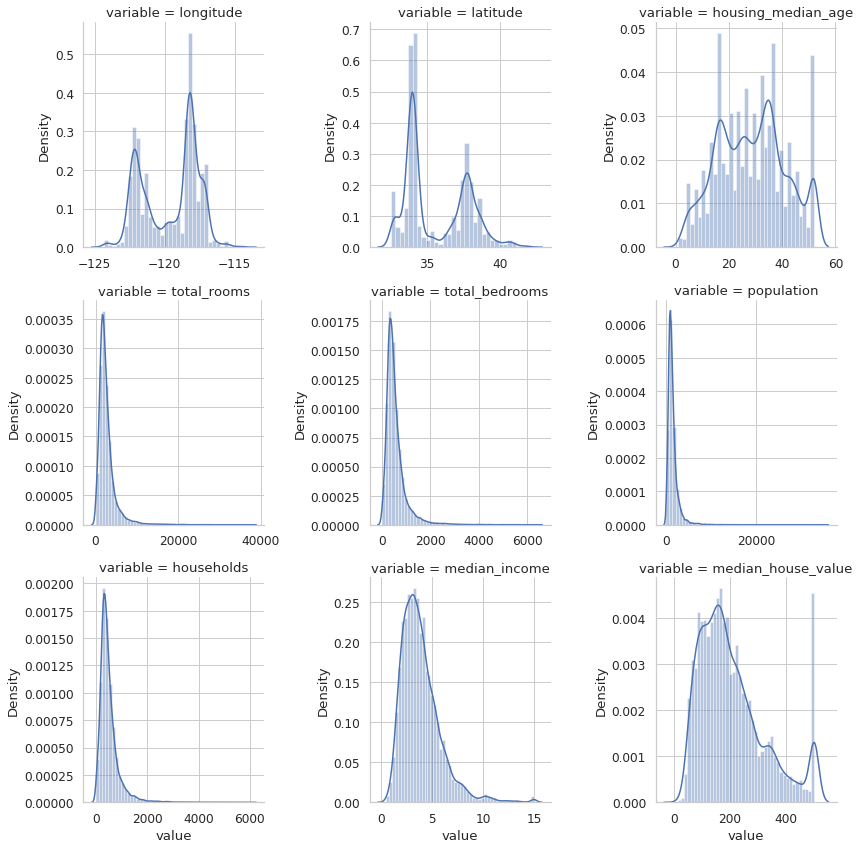

In [7]:
# Distribution of each variable (all are continuous)
g = sns.FacetGrid(training_df.melt(), col="variable", col_wrap=3, height=4,
                  margin_titles=True, sharex=False, sharey=False)
g.map(sns.distplot, "value")

/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


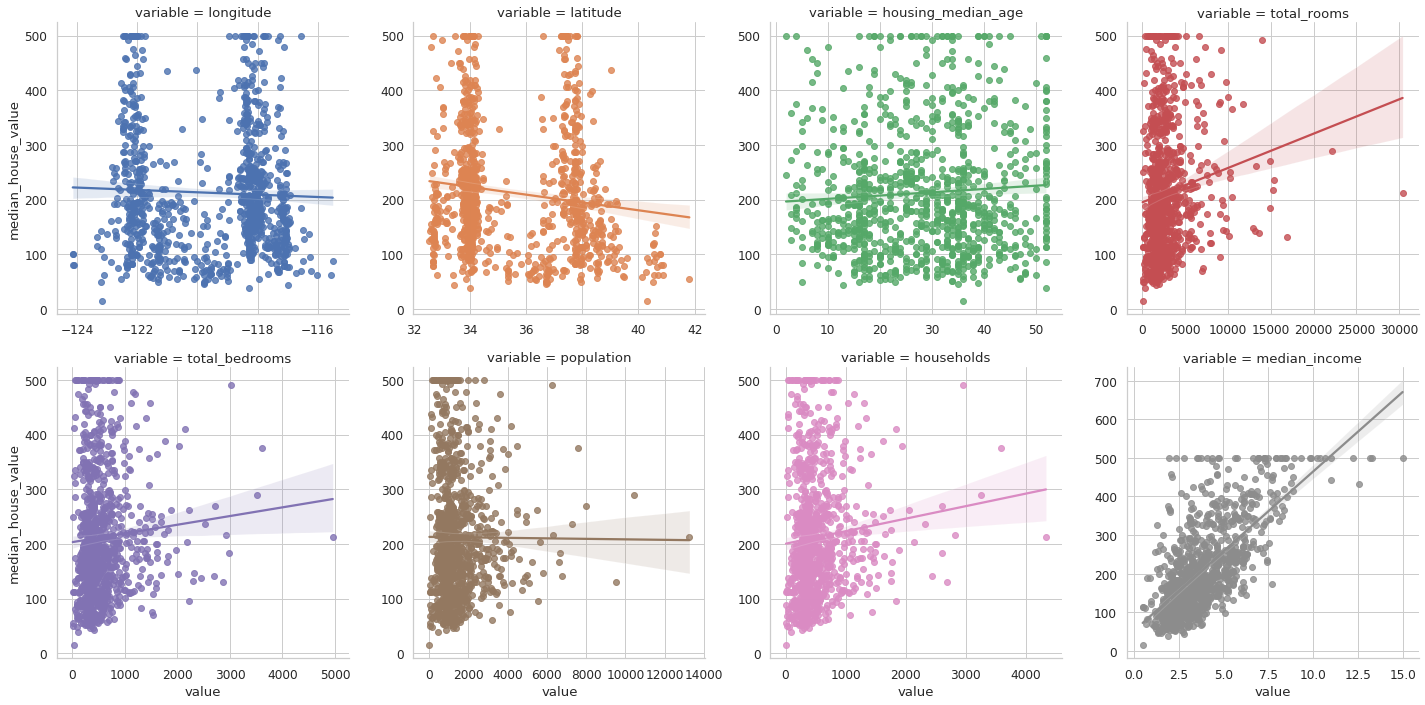

In [8]:
# Plot pairwise relationships with the label
sns.lmplot(x="value", y="median_house_value", data=training_df.sample(1000).melt(id_vars="median_house_value"),
           hue="variable", col="variable", col_wrap=4, sharex=False, sharey=False)

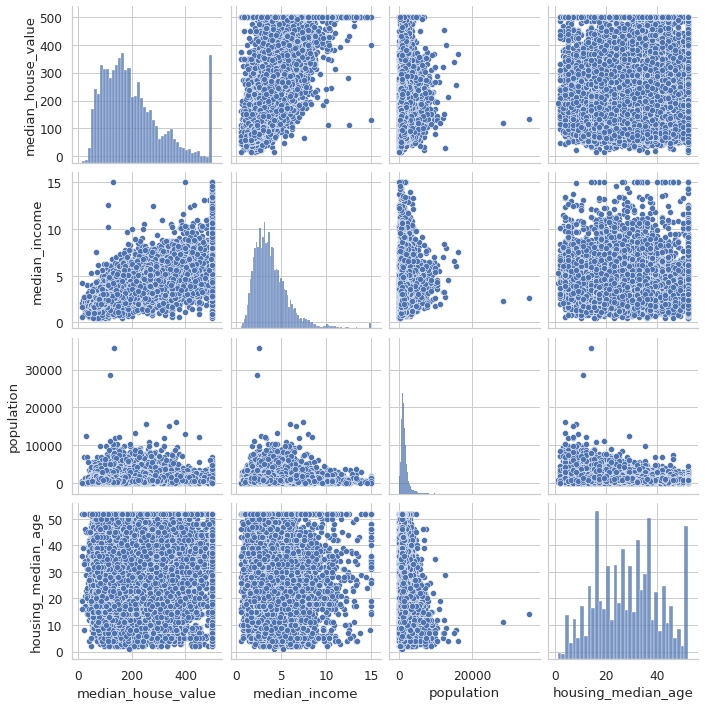

In [9]:
# Examine the likely good predictors
sns.pairplot(training_df, vars=["median_house_value", "median_income", "population", "housing_median_age"])

## Define functions that build and train a model

The following code defines two functions:

  * `build_model(my_learning_rate)`, which builds a randomly-initialized model.
  * `train_model(model, feature, label, epochs)`, which trains the model from the examples (feature and label) you pass. 

Since you don't need to understand model building code right now, we've hidden this code cell.  You may optionally double-click the following headline to see the code that builds and trains a model.

In [10]:
class LinearRegressionModel(torch.nn.Module):

    def __init__(self):
        super().__init__()
        # or super(LinearRegressionModel, self).__init__() for backward compatibility
        self.linear = torch.nn.Linear(1, 1)

    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

## Call the model functions

An important part of machine learning is determining which [features](https://developers.google.com/machine-learning/glossary/#feature) correlate with the [label](https://developers.google.com/machine-learning/glossary/#label). For example, real-life home-value prediction models typically rely on hundreds of features and synthetic features. However, this model relies on only one feature. For now, you'll arbitrarily use `total_rooms` as that feature. 


In [11]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Set model to training mode
        model.train()

        # Forward pass: Compute predicted y by passing x to the model
        yhat = model(x)

        # Computes loss
        loss = loss_fn(yhat, y)

        # Computes gradients (perform backward pass)
        loss.backward()

        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()

        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

## Define plotting functions

The following [matplotlib](https://developers.google.com/machine-learning/glossary/#matplotlib) functions create the following plots:

*  a scatter plot of the feature vs. the label, and a line showing the output of the trained model
*  a loss curve

You may optionally double-click the headline to see the matplotlib code, but note that writing matplotlib code is not an important part of learning ML programming.

In [12]:
def plot_model(x, y, slope, intercept, losses):
    # Scatter plot
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    sns.regplot(x, y, ax=ax[0])
    ax[0].axhline(y=0, color='k', linewidth=1)  # added because i want the origin
    ax[0].axvline(x=0, color='k', linewidth=1)

    # Regression line
    x_pred = np.linspace(x.min() - 0.2, x.max() + 0.2, 50)
    y_pred = (x_pred * slope) + intercept
    sns.lineplot(x=x_pred, y=y_pred, ax=ax[0])
    
    # Loss
    epochs = np.arange(len(losses))
    sns.scatterplot(epochs, losses, ax=ax[1])
    sns.lineplot(epochs, losses, ax=ax[1])

## Model training

In [13]:
# This time we create a Dataset to hold our tensors, because there's a lot
# of observations and we want to perform mini-batch gradient descent (or SGD).
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, df, x_col, y_col):
        self.x = torch.from_numpy(df[x_col].values.reshape(-1, 1)).float()
        self.y = torch.from_numpy(df[y_col].values.reshape(-1, 1)).float()
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

In [14]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 30
batch_size = 30

# Specify the feature and the label.
my_feature = "median_income"  # the total number of rooms on a specific city block.
my_label="median_house_value" # the median value of a house on a specific city block.

In [15]:
from barbar import Bar
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
import math

# Discard any pre-existing version of the model.
model = None

# Create Dataset to hold the training data
dat = CustomDataset(training_df, my_feature, my_label)
train_ds, valid_ds = train_test_split(dat, test_size=0.2)
train_loader=DataLoader(train_ds,batch_size=batch_size,shuffle=True)
valid_loader=DataLoader(valid_ds,batch_size=batch_size,shuffle=False)

# Define the model
torch.manual_seed(42)
model = LinearRegressionModel().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# Train model
losses = []

epoch_train_loss = []

epoch_valid_loss = []

for epoch in range(epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for x_batch, y_batch in Bar(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # print(X)
        y_hat = model(x_batch)
        loss = criterion(y_hat, y_batch) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        losses.append(loss.item())
        train_loss.append(loss.item())
        
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append((train_loss))
   
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    valid_loss = []
    
    # Iterate the validation set by batches.
    for x_batch, y_batch in Bar(valid_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device) 
       
        y_hat = model(x_batch)
        loss = criterion(y_hat, y_batch) #rmse
        
        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        
     # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    epoch_valid_loss.append((valid_loss))
        
    # Print the information.
    display(f"[ Epoch | {epoch + 1:03d}/{epochs:03d} ] \
          train_loss = {train_loss:.5f} root_mean_squared_error = {(train_loss):.5f}  | \
          valid_loss = {valid_loss:.5f} val_root_mean_squared_error = {(valid_loss):.5f}")

print("Defined the build_model and train_model functions.")

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 001/030 ]           train_loss = 7110.74995 root_mean_squared_error = 7110.74995  |           valid_loss = 7854.20309 val_root_mean_squared_error = 7854.20309'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 002/030 ]           train_loss = 6862.20205 root_mean_squared_error = 6862.20205  |           valid_loss = 7781.52461 val_root_mean_squared_error = 7781.52461'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 003/030 ]           train_loss = 6870.30092 root_mean_squared_error = 6870.30092  |           valid_loss = 7779.64104 val_root_mean_squared_error = 7779.64104'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 004/030 ]           train_loss = 6874.59086 root_mean_squared_error = 6874.59086  |           valid_loss = 7922.12490 val_root_mean_squared_error = 7922.12490'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 005/030 ]           train_loss = 6867.84053 root_mean_squared_error = 6867.84053  |           valid_loss = 8331.05108 val_root_mean_squared_error = 8331.05108'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 006/030 ]           train_loss = 6897.46640 root_mean_squared_error = 6897.46640  |           valid_loss = 7786.15241 val_root_mean_squared_error = 7786.15241'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 007/030 ]           train_loss = 6890.89371 root_mean_squared_error = 6890.89371  |           valid_loss = 7775.73624 val_root_mean_squared_error = 7775.73624'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 008/030 ]           train_loss = 6874.88441 root_mean_squared_error = 6874.88441  |           valid_loss = 7806.77315 val_root_mean_squared_error = 7806.77315'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 009/030 ]           train_loss = 6905.15928 root_mean_squared_error = 6905.15928  |           valid_loss = 8724.88741 val_root_mean_squared_error = 8724.88741'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 010/030 ]           train_loss = 6886.37768 root_mean_squared_error = 6886.37768  |           valid_loss = 7832.99258 val_root_mean_squared_error = 7832.99258'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 011/030 ]           train_loss = 6869.64900 root_mean_squared_error = 6869.64900  |           valid_loss = 8022.76338 val_root_mean_squared_error = 8022.76338'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 012/030 ]           train_loss = 6892.54158 root_mean_squared_error = 6892.54158  |           valid_loss = 7929.91947 val_root_mean_squared_error = 7929.91947'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 013/030 ]           train_loss = 6896.50867 root_mean_squared_error = 6896.50867  |           valid_loss = 7833.55197 val_root_mean_squared_error = 7833.55197'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 014/030 ]           train_loss = 6883.59033 root_mean_squared_error = 6883.59033  |           valid_loss = 7788.55425 val_root_mean_squared_error = 7788.55425'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 015/030 ]           train_loss = 6883.51095 root_mean_squared_error = 6883.51095  |           valid_loss = 7820.04086 val_root_mean_squared_error = 7820.04086'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 016/030 ]           train_loss = 6881.96020 root_mean_squared_error = 6881.96020  |           valid_loss = 7864.90627 val_root_mean_squared_error = 7864.90627'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 017/030 ]           train_loss = 6878.45873 root_mean_squared_error = 6878.45873  |           valid_loss = 7930.32218 val_root_mean_squared_error = 7930.32218'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 018/030 ]           train_loss = 6898.32967 root_mean_squared_error = 6898.32967  |           valid_loss = 7797.45457 val_root_mean_squared_error = 7797.45457'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 019/030 ]           train_loss = 6872.56160 root_mean_squared_error = 6872.56160  |           valid_loss = 7779.85385 val_root_mean_squared_error = 7779.85385'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 020/030 ]           train_loss = 6890.54137 root_mean_squared_error = 6890.54137  |           valid_loss = 7820.23862 val_root_mean_squared_error = 7820.23862'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 021/030 ]           train_loss = 6890.76962 root_mean_squared_error = 6890.76962  |           valid_loss = 7889.24037 val_root_mean_squared_error = 7889.24037'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 022/030 ]           train_loss = 6887.68882 root_mean_squared_error = 6887.68882  |           valid_loss = 7974.39110 val_root_mean_squared_error = 7974.39110'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 023/030 ]           train_loss = 6874.85628 root_mean_squared_error = 6874.85628  |           valid_loss = 7781.70779 val_root_mean_squared_error = 7781.70779'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 024/030 ]           train_loss = 6879.92579 root_mean_squared_error = 6879.92579  |           valid_loss = 7893.67589 val_root_mean_squared_error = 7893.67589'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 025/030 ]           train_loss = 6863.21088 root_mean_squared_error = 6863.21088  |           valid_loss = 7809.44193 val_root_mean_squared_error = 7809.44193'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 026/030 ]           train_loss = 6870.86148 root_mean_squared_error = 6870.86148  |           valid_loss = 7785.08302 val_root_mean_squared_error = 7785.08302'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 027/030 ]           train_loss = 6858.66058 root_mean_squared_error = 6858.66058  |           valid_loss = 7820.38637 val_root_mean_squared_error = 7820.38637'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 028/030 ]           train_loss = 6882.48249 root_mean_squared_error = 6882.48249  |           valid_loss = 7777.25542 val_root_mean_squared_error = 7777.25542'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 029/030 ]           train_loss = 6911.48806 root_mean_squared_error = 6911.48806  |           valid_loss = 7901.43150 val_root_mean_squared_error = 7901.43150'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 030/030 ]           train_loss = 6891.83687 root_mean_squared_error = 6891.83687  |           valid_loss = 7870.41996 val_root_mean_squared_error = 7870.41996'

Defined the build_model and train_model functions.


The predicted model is: y =  44.952x +  44.419


/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an 

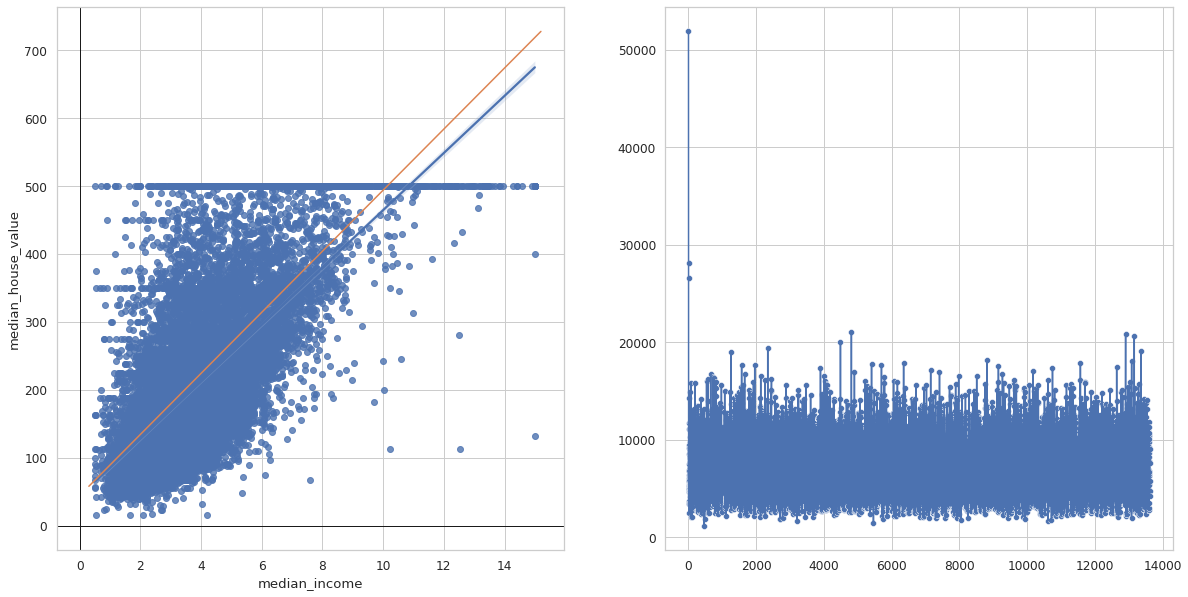

In [16]:
# Check parameters
model_beta_0 = model.state_dict()["linear.bias"].item()
model_beta_1 = model.state_dict()["linear.weight"].item()
print(f"The predicted model is: y = {model_beta_1: .3f}x + {model_beta_0: .3f}")

plot_model(training_df[my_feature], training_df[my_label], model_beta_1, model_beta_0, losses)

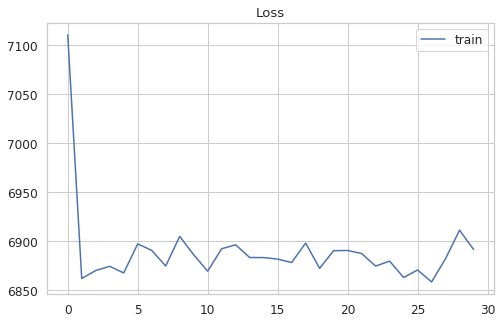

In [17]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(epoch_train_loss)
plt.title('Loss')
plt.legend(['train'])
plt.savefig('loss.png')
plt.show()

In [18]:
df_batch = training_df[[my_feature, my_label]].sample(10)
df_batch["predicted_price"] = model(torch.from_numpy(df_batch[my_feature].values.reshape(-1, 1)).float().cuda()).cpu().detach().numpy()

df_batch

,median_income,median_house_value,predicted_price
12276,2.0,210.7,133.1
15631,3.1,79.0,183.2
7020,4.1,323.7,230.5
3946,4.4,334.1,243.9
10221,2.5,74.6,156.0
7504,2.8,242.0,169.9
2683,3.1,137.2,183.7
2142,2.8,82.2,168.5
11879,5.7,155.7,301.6
14320,3.0,157.1,177.1


In [19]:
# The following variables are the hyperparameters.
my_feature = "median_income" # Pick a feature other than "total_rooms"

# Possibly, experiment with the hyperparameters.
learning_rate = 0.01
epochs = 30
batch_size = 30

In [20]:
training_df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')

In [21]:
# from barbar import Bar
from tqdm.notebook import tqdm
from IPython.display import clear_output

# Discard any pre-existing version of the model.
model = None

# Create Dataset to hold the training data
dat = CustomDataset(training_df, my_feature, my_label)
train_ds, valid_ds = train_test_split(dat, test_size=0.2)
train_loader=DataLoader(train_ds,batch_size=batch_size,shuffle=True)
valid_loader=DataLoader(valid_ds,batch_size=batch_size,shuffle=False)

# Define the model
torch.manual_seed(42)
model = LinearRegressionModel().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# Train model
losses = []

epoch_train_loss = []

epoch_valid_loss = []

for epoch in range(epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for x_batch, y_batch in Bar(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # print(X)
        y_hat = model(x_batch)
        loss = criterion(y_hat, y_batch) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        losses.append(loss.item())
        train_loss.append(loss.item())
        
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append((train_loss))
   
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    valid_loss = []
    
    # Iterate the validation set by batches.
    for x_batch, y_batch in Bar(valid_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device) 
       
        y_hat = model(x_batch)
        loss = criterion(y_hat, y_batch) #rmse
        
        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        
     # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    epoch_valid_loss.append((valid_loss))
        
    # Print the information.
    display(f"[ Epoch | {epoch + 1:03d}/{epochs:03d} ] \
          train_loss = {train_loss:.5f} root_mean_squared_error = {(train_loss):.5f}  | \
          valid_loss = {valid_loss:.5f} val_root_mean_squared_error = {(valid_loss):.5f}")

print("Defined the build_model and train_model functions.")

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 001/030 ]           train_loss = 7276.75769 root_mean_squared_error = 7276.75769  |           valid_loss = 7354.03415 val_root_mean_squared_error = 7354.03415'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 002/030 ]           train_loss = 7040.70837 root_mean_squared_error = 7040.70837  |           valid_loss = 7456.85327 val_root_mean_squared_error = 7456.85327'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 003/030 ]           train_loss = 7020.52644 root_mean_squared_error = 7020.52644  |           valid_loss = 7291.41333 val_root_mean_squared_error = 7291.41333'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 004/030 ]           train_loss = 7024.52734 root_mean_squared_error = 7024.52734  |           valid_loss = 7319.46507 val_root_mean_squared_error = 7319.46507'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 005/030 ]           train_loss = 7026.39433 root_mean_squared_error = 7026.39433  |           valid_loss = 7358.14475 val_root_mean_squared_error = 7358.14475'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 006/030 ]           train_loss = 7021.60200 root_mean_squared_error = 7021.60200  |           valid_loss = 7459.74758 val_root_mean_squared_error = 7459.74758'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 007/030 ]           train_loss = 7024.25606 root_mean_squared_error = 7024.25606  |           valid_loss = 7360.50388 val_root_mean_squared_error = 7360.50388'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 008/030 ]           train_loss = 7022.96995 root_mean_squared_error = 7022.96995  |           valid_loss = 7262.56379 val_root_mean_squared_error = 7262.56379'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 009/030 ]           train_loss = 7007.68463 root_mean_squared_error = 7007.68463  |           valid_loss = 7263.81961 val_root_mean_squared_error = 7263.81961'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 010/030 ]           train_loss = 7020.41664 root_mean_squared_error = 7020.41664  |           valid_loss = 7678.00980 val_root_mean_squared_error = 7678.00980'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 011/030 ]           train_loss = 7016.77963 root_mean_squared_error = 7016.77963  |           valid_loss = 7603.55096 val_root_mean_squared_error = 7603.55096'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 012/030 ]           train_loss = 7029.99024 root_mean_squared_error = 7029.99024  |           valid_loss = 7372.34828 val_root_mean_squared_error = 7372.34828'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 013/030 ]           train_loss = 7020.68037 root_mean_squared_error = 7020.68037  |           valid_loss = 7314.03254 val_root_mean_squared_error = 7314.03254'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 014/030 ]           train_loss = 7017.11603 root_mean_squared_error = 7017.11603  |           valid_loss = 7297.87527 val_root_mean_squared_error = 7297.87527'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 015/030 ]           train_loss = 7016.70179 root_mean_squared_error = 7016.70179  |           valid_loss = 7500.54151 val_root_mean_squared_error = 7500.54151'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 016/030 ]           train_loss = 7021.81144 root_mean_squared_error = 7021.81144  |           valid_loss = 7311.73935 val_root_mean_squared_error = 7311.73935'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 017/030 ]           train_loss = 7025.94034 root_mean_squared_error = 7025.94034  |           valid_loss = 7321.00506 val_root_mean_squared_error = 7321.00506'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 018/030 ]           train_loss = 7023.32970 root_mean_squared_error = 7023.32970  |           valid_loss = 7268.79826 val_root_mean_squared_error = 7268.79826'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 019/030 ]           train_loss = 7003.44044 root_mean_squared_error = 7003.44044  |           valid_loss = 7286.19795 val_root_mean_squared_error = 7286.19795'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 020/030 ]           train_loss = 7031.20846 root_mean_squared_error = 7031.20846  |           valid_loss = 7348.84091 val_root_mean_squared_error = 7348.84091'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 021/030 ]           train_loss = 7038.93267 root_mean_squared_error = 7038.93267  |           valid_loss = 7360.83370 val_root_mean_squared_error = 7360.83370'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 022/030 ]           train_loss = 7010.65734 root_mean_squared_error = 7010.65734  |           valid_loss = 7366.07410 val_root_mean_squared_error = 7366.07410'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 023/030 ]           train_loss = 7041.69791 root_mean_squared_error = 7041.69791  |           valid_loss = 7403.12947 val_root_mean_squared_error = 7403.12947'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 024/030 ]           train_loss = 7033.16808 root_mean_squared_error = 7033.16808  |           valid_loss = 7320.67548 val_root_mean_squared_error = 7320.67548'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 025/030 ]           train_loss = 7021.06863 root_mean_squared_error = 7021.06863  |           valid_loss = 7269.36617 val_root_mean_squared_error = 7269.36617'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 026/030 ]           train_loss = 7022.23133 root_mean_squared_error = 7022.23133  |           valid_loss = 7490.02274 val_root_mean_squared_error = 7490.02274'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 027/030 ]           train_loss = 7016.73947 root_mean_squared_error = 7016.73947  |           valid_loss = 8849.27484 val_root_mean_squared_error = 8849.27484'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 028/030 ]           train_loss = 7027.00329 root_mean_squared_error = 7027.00329  |           valid_loss = 7522.06763 val_root_mean_squared_error = 7522.06763'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 029/030 ]           train_loss = 7008.39250 root_mean_squared_error = 7008.39250  |           valid_loss = 7269.69272 val_root_mean_squared_error = 7269.69272'

13600/13600: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 030/030 ]           train_loss = 7024.14878 root_mean_squared_error = 7024.14878  |           valid_loss = 7285.45330 val_root_mean_squared_error = 7285.45330'

Defined the build_model and train_model functions.


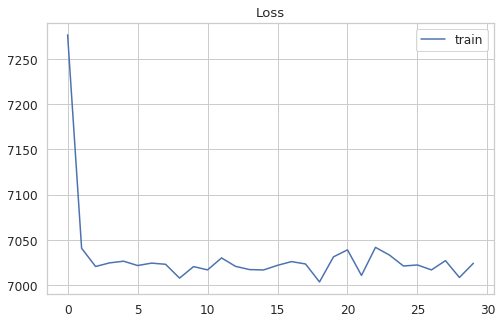

In [22]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(epoch_train_loss)
plt.title('Loss')
plt.legend(['train'])
plt.savefig('loss.png')
plt.show()

In [23]:
# Define a synthetic feature
training_df["rooms_per_person"] = training_df["total_rooms"] / training_df["population"]
my_feature = "rooms_per_person"

# Tune the hyperparameters.
learning_rate = 0.06
epochs = 24
batch_size = 30

In [24]:
# from barbar import Bar
from tqdm.notebook import tqdm
from IPython.display import clear_output

# Discard any pre-existing version of the model.
model = None

# Create Dataset to hold the training data
dat = CustomDataset(training_df, my_feature, my_label)
train_loader = DataLoader(dataset=dat, batch_size=batch_size, shuffle=True)

# Define the model
torch.manual_seed(42)
model = LinearRegressionModel().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# Train model
losses = []

epoch_train_loss = []

epoch_valid_loss = []

for epoch in range(epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for x_batch, y_batch in Bar(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # print(X)
        y_hat = model(x_batch)
        loss = criterion(y_hat, y_batch) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        losses.append(loss.item())
        train_loss.append(loss.item())
        
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append((train_loss))
   
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    valid_loss = []
    
    # Iterate the validation set by batches.
    for x_batch, y_batch in Bar(valid_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device) 
       
        y_hat = model(x_batch)
        loss = criterion(y_hat, y_batch) #rmse
        
        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        
     # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    epoch_valid_loss.append((valid_loss))
        
    # Print the information.
    display(f"[ Epoch | {epoch + 1:03d}/{epochs:03d} ] \
          train_loss = {train_loss:.5f} root_mean_squared_error = {(train_loss):.5f}  | \
          valid_loss = {valid_loss:.5f} val_root_mean_squared_error = {(valid_loss):.5f}")

print("Defined the build_model and train_model functions.")

17000/17000: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 001/024 ]           train_loss = 14545.24755 root_mean_squared_error = 14545.24755  |           valid_loss = 22138.15335 val_root_mean_squared_error = 22138.15335'

17000/17000: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 002/024 ]           train_loss = 17253.02325 root_mean_squared_error = 17253.02325  |           valid_loss = 9590.80385 val_root_mean_squared_error = 9590.80385'

17000/17000: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 003/024 ]           train_loss = 16805.41194 root_mean_squared_error = 16805.41194  |           valid_loss = 11236.84981 val_root_mean_squared_error = 11236.84981'

17000/17000: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 004/024 ]           train_loss = 15252.05627 root_mean_squared_error = 15252.05627  |           valid_loss = 20266.94597 val_root_mean_squared_error = 20266.94597'

17000/17000: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 005/024 ]           train_loss = 15056.93814 root_mean_squared_error = 15056.93814  |           valid_loss = 10159.35612 val_root_mean_squared_error = 10159.35612'

17000/17000: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 006/024 ]           train_loss = 16199.46968 root_mean_squared_error = 16199.46968  |           valid_loss = 14048.99661 val_root_mean_squared_error = 14048.99661'

17000/17000: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 007/024 ]           train_loss = 17617.38437 root_mean_squared_error = 17617.38437  |           valid_loss = 13165.14103 val_root_mean_squared_error = 13165.14103'

17000/17000: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 008/024 ]           train_loss = 15670.92099 root_mean_squared_error = 15670.92099  |           valid_loss = 11527.94708 val_root_mean_squared_error = 11527.94708'

17000/17000: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 009/024 ]           train_loss = 16707.52888 root_mean_squared_error = 16707.52888  |           valid_loss = 19838.96920 val_root_mean_squared_error = 19838.96920'

17000/17000: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 010/024 ]           train_loss = 15245.02304 root_mean_squared_error = 15245.02304  |           valid_loss = 10532.14193 val_root_mean_squared_error = 10532.14193'

17000/17000: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 011/024 ]           train_loss = 15937.96250 root_mean_squared_error = 15937.96250  |           valid_loss = 10480.45207 val_root_mean_squared_error = 10480.45207'

17000/17000: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 012/024 ]           train_loss = 15974.28807 root_mean_squared_error = 15974.28807  |           valid_loss = 13873.23772 val_root_mean_squared_error = 13873.23772'

17000/17000: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 013/024 ]           train_loss = 14214.39415 root_mean_squared_error = 14214.39415  |           valid_loss = 12656.81343 val_root_mean_squared_error = 12656.81343'

17000/17000: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 014/024 ]           train_loss = 15590.42371 root_mean_squared_error = 15590.42371  |           valid_loss = 11388.15362 val_root_mean_squared_error = 11388.15362'

17000/17000: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 015/024 ]           train_loss = 17411.22642 root_mean_squared_error = 17411.22642  |           valid_loss = 19622.12061 val_root_mean_squared_error = 19622.12061'

17000/17000: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 016/024 ]           train_loss = 15331.87234 root_mean_squared_error = 15331.87234  |           valid_loss = 14603.62628 val_root_mean_squared_error = 14603.62628'

17000/17000: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 017/024 ]           train_loss = 15162.06329 root_mean_squared_error = 15162.06329  |           valid_loss = 18536.99622 val_root_mean_squared_error = 18536.99622'

17000/17000: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 018/024 ]           train_loss = 15532.82407 root_mean_squared_error = 15532.82407  |           valid_loss = 9477.21388 val_root_mean_squared_error = 9477.21388'

17000/17000: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 019/024 ]           train_loss = 16299.37169 root_mean_squared_error = 16299.37169  |           valid_loss = 10777.58749 val_root_mean_squared_error = 10777.58749'

17000/17000: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 020/024 ]           train_loss = 16150.46149 root_mean_squared_error = 16150.46149  |           valid_loss = 10434.48627 val_root_mean_squared_error = 10434.48627'

17000/17000: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 021/024 ]           train_loss = 15526.15843 root_mean_squared_error = 15526.15843  |           valid_loss = 14839.75241 val_root_mean_squared_error = 14839.75241'

17000/17000: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 022/024 ]           train_loss = 17350.10012 root_mean_squared_error = 17350.10012  |           valid_loss = 17015.96301 val_root_mean_squared_error = 17015.96301'

17000/17000: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 023/024 ]           train_loss = 14560.05188 root_mean_squared_error = 14560.05188  |           valid_loss = 8984.34947 val_root_mean_squared_error = 8984.34947'

17000/17000: [===============================>] - ETA 0.0s
3400/3400: [===============================>] - ETA 0.0s


'[ Epoch | 024/024 ]           train_loss = 15093.80281 root_mean_squared_error = 15093.80281  |           valid_loss = 12552.22594 val_root_mean_squared_error = 12552.22594'

Defined the build_model and train_model functions.


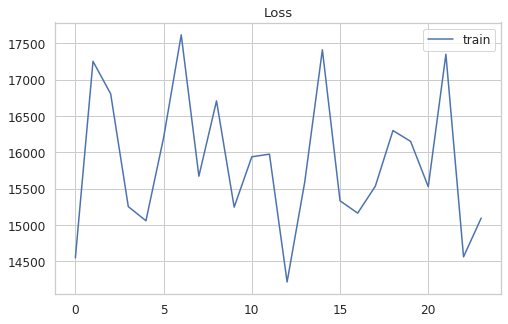

In [25]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(epoch_train_loss)
plt.title('Loss')
plt.legend(['train'])
plt.savefig('loss.png')
plt.show()

## Task 5. Find feature(s) whose raw values correlate with the label

So far, we've relied on trial-and-error to identify possible features for the model.  Let's rely on statistics instead.

A **correlation matrix** indicates how each attribute's raw values relate to the other attributes' raw values. Correlation values have the following meanings:

  * `1.0`: perfect positive correlation; that is, when one attribute rises, the other attribute rises.
  * `-1.0`: perfect negative correlation; that is, when one attribute rises, the other attribute falls. 
  * `0.0`: no correlation; the two columns [are not linearly related](https://en.wikipedia.org/wiki/Correlation_and_dependence#/media/File:Correlation_examples2.svg).

In general, the higher the absolute value of a correlation value, the greater its predictive power. For example, a correlation value of -0.8 implies far more predictive power than a correlation of -0.2.

The following code cell generates the correlation matrix for attributes of the California Housing Dataset:

In [26]:
# Generate a correlation matrix.
training_df.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_person
longitude,1.0,-0.9,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.0,-0.1
latitude,-0.9,1.0,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,-0.1,0.1
housing_median_age,-0.1,0.0,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,0.1,-0.1
total_rooms,0.0,-0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1,0.1
total_bedrooms,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0,0.0
population,0.1,-0.1,-0.3,0.9,0.9,1.0,0.9,-0.0,-0.0,-0.1
households,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,0.0,0.1,-0.0
median_income,-0.0,-0.1,-0.1,0.2,-0.0,-0.0,0.0,1.0,0.7,0.2
median_house_value,-0.0,-0.1,0.1,0.1,0.0,-0.0,0.1,0.7,1.0,0.2
rooms_per_person,-0.1,0.1,-0.1,0.1,0.0,-0.1,-0.0,0.2,0.2,1.0
